In [154]:
# GD with momentum: https://github.com/VinitSR7/Logistic-Regression-with-Advanced-Optimizers/blob/master/SGD%20with%20Momentum.ipynb
# Benchmarks: https://arxiv.org/pdf/2306.07179, https://openreview.net/pdf?id=HygrAR4tPS
# Add a learning rate scechdule
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit, expit
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import accuracy_score
import pandas as pd

def c_and_cprime(t, pars):
    c = pars['c0'] * np.exp(-pars['gamma'] * t)
    cp = -pars['gamma'] * pars['c0'] * np.exp(-pars['gamma'] * t)
    return c, cp

def solve_p(p0, F, h, pars):
    p = p0.copy()
    eps_reg = 1e-5
    # First RK4 step (g1)
    pdotF = np.dot(p, F)
    pdotp = np.dot(p, p) + eps_reg
    g1 = F - (pdotF / pdotp) * p - 0.5 * pars['gamma'] * p
    # Second RK4 step (g2)
    p = p0 + 0.5 * h * g1
    pdotF = np.dot(p, F)
    pdotp = np.dot(p, p) + eps_reg
    g2 = F - (pdotF / pdotp) * p - 0.5 * pars['gamma'] * p
    # Third RK4 step (g3)
    p = p0 + 0.5 * h * g2
    pdotF = np.dot(p, F)
    pdotp = np.dot(p, p) + eps_reg
    g3 = F - (pdotF / pdotp) * p - 0.5 * pars['gamma'] * p
    # Fourth RK4 step (g4)
    p = p0 + h * g3
    pdotF = np.dot(p, F)
    pdotp = np.dot(p, p) + eps_reg
    g4 = F - (pdotF / pdotp) * p - 0.5 * pars['gamma'] * p
    # Final RK4 update for p1
    p1 = p0 + (h / 6) * (g1 + 2 * g2 + 2 * g3 + g4)
    return p1

def kd_step(w, p, h, pars, Force):
    w, p, Force = w.reshape(-1), p.reshape(-1), Force.reshape(-1)
    w = w + 0.5 * h * p
    p = solve_p(p, Force, h, pars)
    w = w + 0.5 * h * p
    return w.reshape(-1,1), p.reshape(-1,1)

def hd_step(w, p, h, pars, Force):
    gamma = pars['gamma']
    delta = 1/(1 + gamma * h)
    p = delta * p + h * delta * Force
    w = w + h * p
    return w, p

def gd_step(w, p, h, Force):
    w = w + h * Force
    return w, p

def adam_step(w, p, m, h, t, pars, Force):
    m = pars['b1'] * m - (1 - pars['b1']) * Force
    p = pars['b2'] * p + (1 - pars['b1']) * Force**2
    b = np.sqrt(1 - pars['b2']**(t+1))/(1 - pars['b1']**(t+1))
    w = w - h * b * (m / (np.sqrt(p) + pars['eps']))
    return w, p, m

def nadam_step(w, p, m, h, t, pars, Force):
    m = pars['b1'] * m - (1 - pars['b1']) * Force
    p = pars['b2'] * p + (1 - pars['b1']) * Force**2
    b = np.sqrt(1 - pars['b2']**(t+1))/(1 - pars['b1']**(t+1))
    w = w - h * b * ((pars['b1'] * m - (1 - pars['b1']) * Force) / (np.sqrt(p) + pars['eps']))
    return w, p, m

def nes_step(w, p, h, pars, Force):
    p = pars['gamma'] * p - Force
    w = w - h * (pars['gamma'] * p - Force)
    return w, p

def phb_step(w, p, h, pars, Force):
    p = pars['gamma'] * p - Force
    w = w - h * p
    return w, p

data = datasets.load_breast_cancer()
X = data['data']
Y = data['target']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify = Y, shuffle = True)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def sigmoid(X):
    return 1/(1+math.exp(-X)) 

def log_loss(y, y_):
    return -1*(y*math.log(sigmoid(y_)) + (1-y)*math.log(1-sigmoid(y_)))

def cal_grad(y,y_,x):
    return (y - sigmoid(y_)) * (x.reshape(-1, 1)) 

def train(X, Y, epochs, eta, pars, optimizer, batch_size, lr_decay = 0.):
    np.random.seed(42)
    eta0 = eta
    N = X.shape[1]
    w =  np.random.uniform(-1, 1, size = N).reshape(N, 1)
    if optimizer == 'hd' or optimizer == 'kd':
        p = np.random.uniform(-1, 1, size = N).reshape(N, 1)
    if optimizer == 'kd':
        p = (p / np.linalg.norm(p)) * np.sqrt(2 * pars['c0'])
    else:
        p = np.zeros_like(w)
        m = np.zeros_like(w)
    losses = []
    ps = [p]
    t = 0
    for epoch in range(epochs):
        epoch_loss = 0
        perm = np.random.permutation(len(X))
        for i in range(0, len(X), batch_size):
            gt = 0
            batch_loss = 0
            X_batch = X[perm[i:i + batch_size]]
            Y_batch = Y[perm[i:i + batch_size]]

            for j in range(len(X_batch)):
                y = Y_batch[j]
                x = X_batch[j].reshape(N, 1)
                y_ = np.dot(w.T, x)
                gt += cal_grad(y, y_, x)
                batch_loss += log_loss(y, y_)
            
            gt /= batch_size
            batch_loss /= batch_size
            if np.linalg.norm(gt) < 1e-5:
                break
            if optimizer == 'gd':
                w, p = gd_step(w, p, eta, gt)
            elif optimizer == 'hd':
                w, p = hd_step(w, p, eta, pars, gt)
            elif optimizer == 'kd':
                w, p = kd_step(w, p, eta, pars, gt)
            elif optimizer == 'phb':
                w, p = phb_step(w, p, eta, pars, gt)
            elif optimizer == 'nes':
                w, p = nes_step(w, p, eta, pars, gt)
            elif optimizer == 'adam':
                w, p, m = adam_step(w, p, m, eta, t, pars, gt)
            elif optimizer == 'nadam':
                w, p, m = nadam_step(w, p, m, eta, t, pars, gt)
            epoch_loss += batch_loss
            t += eta
        ps.append(p)
        losses.append(epoch_loss)
        eta = eta0 * np.exp(-lr_decay * epoch)
    ps = np.array(ps)
    return w, np.array(ps), np.array(losses)

pars_kd = {
    'c0': 1.,
    'gamma': 0.9
    }
pars_hd = {
    'gamma': 0.9
    }
pars_gd = {}
pars_phb = {
    'gamma': 0.9
}
pars_nes = {
    'gamma': 0.9
}
pars_adam = {
    'b1': 0.9,
    'b2': 0.999,
    'eps': 1e-8
}
pars_nadam = {
    'b1': 0.9,
    'b2': 0.999,
    'eps': 1e-7
}

epochs = 10000
eta = 1e-3
batch_size = 426
w_kd, ps, loss_kd = train(X_train, Y_train, epochs, eta, pars_kd, optimizer = 'kd', batch_size = batch_size)
#T = np.arange(epochs + 1) * eta * (np.ceil(len(X_train) // batch_size))
#plt.plot(T, (0.5 * np.linalg.norm(ps, axis=1)**2).reshape(-1), label = 'KE')
#plt.plot(T, (pars_kd['c0'] * np.exp(-pars_kd['gamma'] * T)).reshape(-1), label = 'c(t)')
#plt.legend()
w_hd, ps, loss_hd = train(X_train, Y_train, epochs, eta, pars_hd, optimizer = 'hd', batch_size = batch_size)
w_gd, ps, loss_gd = train(X_train, Y_train, epochs, eta, pars_gd, optimizer = 'gd', batch_size = batch_size)
#w_phb, ps, loss_phb = train(X_train, Y_train, epochs, eta, pars_phb, optimizer = 'phb', batch_size = batch_size)
#w_nes, ps, loss_nes = train(X_train, Y_train, epochs, eta, pars_nes, optimizer = 'nes', batch_size = batch_size)
#w_adam, ps, loss_adam = train(X_train, Y_train, epochs, eta, pars_adam, optimizer = 'adam', batch_size = batch_size)
w_nadam, ps, loss_nadam = train(X_train, Y_train, epochs, eta, pars_nadam, optimizer = 'nadam', batch_size = batch_size)

,Train Accuracy,Test Accuracy
KD,0.957746,0.986014
HD,0.978873,0.979021
GD,0.969484,0.986014
NADAM,0.910798,0.951049


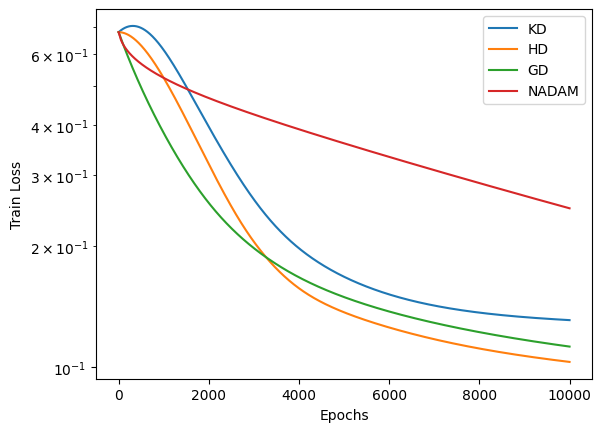

In [155]:
def predict(w, X):
    y_pred = []
    for i in range(len(X)):
        y_pred.append(np.round(sigmoid(np.dot(w.T, X[i].reshape(X.shape[1], 1)))))
    return y_pred

# Plotting the train loss curves for all optimizers
plt.semilogy(np.arange(epochs), loss_kd, label='KD')
plt.semilogy(np.arange(epochs), loss_hd, label='HD')
plt.semilogy(np.arange(epochs), loss_gd, label='GD')
#plt.semilogy(np.arange(epochs), loss_phb, label='PHB')
#plt.semilogy(np.arange(epochs), loss_adam, label='ADAM')
plt.semilogy(np.arange(epochs), loss_nadam, label='NADAM')
#plt.semilogy(np.arange(epochs), loss_nes, label='NES')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.legend()

# Calculating train accuracies for all optimizers
train_acc_kd = accuracy_score(Y_train, predict(w_kd, X_train))
train_acc_hd = accuracy_score(Y_train, predict(w_hd, X_train))
train_acc_gd = accuracy_score(Y_train, predict(w_gd, X_train))
#train_acc_phb = accuracy_score(Y_train, predict(w_phb, X_train))
#train_acc_adam = accuracy_score(Y_train, predict(w_adam, X_train))
train_acc_nadam = accuracy_score(Y_train, predict(w_nadam, X_train))
#train_acc_nes = accuracy_score(Y_train, predict(w_nes, X_train))

# Calculating test accuracies for all optimizers
test_acc_kd = accuracy_score(Y_test, predict(w_kd, X_test))
test_acc_hd = accuracy_score(Y_test, predict(w_hd, X_test))
test_acc_gd = accuracy_score(Y_test, predict(w_gd, X_test))
#test_acc_phb = accuracy_score(Y_test, predict(w_phb, X_test))
#test_acc_adam = accuracy_score(Y_test, predict(w_adam, X_test))
test_acc_nadam = accuracy_score(Y_test, predict(w_nadam, X_test))
#test_acc_nes = accuracy_score(Y_test, predict(w_nes, X_test))

accuracy_data = {
    'Train Accuracy': [
        train_acc_kd, train_acc_hd, train_acc_gd, train_acc_nadam#, train_acc_nes
    ],
    'Test Accuracy': [
        test_acc_kd, test_acc_hd, test_acc_gd, test_acc_nadam#, test_acc_nes
    ]
}

index = ['KD', 'HD', 'GD', 'NADAM']
accuracy_df = pd.DataFrame(accuracy_data, index=index)
accuracy_df
